#**Install**

In [ ]:
pip install spacy

In [ ]:
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 14.7 MB 9.5 MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-py3-none-any.whl size=14727026 sha256=725ddf2c92c8e812a3ddcaf1d681d2a9c0664549c3a599e496cdc9be1a1000fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-8fitpd49/wheels/c9/a6/ea/0778337c34660027ee67ef3a91fb9d3600b76777a912ea1c24
Successfully built fr-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
!pip install -q tensorflow_datasets

#**Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score 
import collections
import nltk
import tensorflow_datasets as tfds
from keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM,Dense, Embedding, LayerNormalization
from keras.preprocessing.text import Tokenizer
import os

# **Load Data and Preprocessing** 

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("val.csv")

In [ ]:
def clean_text( string: str, punctuations=r'''!()[]{};:'"\,<>./?@#%^&*_''') -> str:
  #on enleve les chiffres
    string=re.sub(r'[0-9]+','',string)
  #on enleve la ponctuation
    for x in string.lower():
      if x in punctuations:
        string=string.replace(x," ")
  #on met en miniscule
    string=string.lower()
    return string

In [ ]:
df_list=[clean_text(x) for x in df_train['RawText'].astype(str)]
df_train = pd.DataFrame(list(zip(df_list, list(df_train['ICD10']))), columns =['RawText', 'ICD10'])

df_list=[clean_text(x) for x in df_test['RawText'].astype(str)]
df_test = pd.DataFrame(list(zip(df_list, list(df_test['ICD10']))), columns =['RawText', 'ICD10'])

df_list=[clean_text(x) for x in df_val['RawText'].astype(str)]
df_val = pd.DataFrame(list(zip(df_list, list(df_val['ICD10']))), columns =['RawText', 'ICD10'])

In [ ]:
df_labels=pd.concat([df_train['ICD10'], df_test['ICD10'],df_val['ICD10']])
labels=preprocessing.LabelEncoder().fit_transform(df_labels)

y_train = labels[:181763]
y_test = labels[181763:211763]
y_val = labels[211763:241763]

# **Exercice 1 :** Description du jeu de données

In [ ]:
df = pd.concat([df_train, df_test, df_val], axis=0)

In [ ]:
df.head(2)

,RawText,ICD10
0,thrombose veineuse profonde cuisse gauche,I802
1,hémiplégie post-traumatique,S099


In [ ]:
df['ICD10'].value_counts()

S062    1472
C798    1343
C859    1067
C349     998
Z924     850
        ... 
K65        1
Y462       1
F650       1
T529       1
T366       1
Name: ICD10, Length: 9541, dtype: int64

In [ ]:
uniqueWords = list(set(" ".join(df['RawText']).lower().split(" ")))
nbWords = len(uniqueWords)
print("Il existe: "+str(nbWords)+" mots différents dans nos données textuelles.")

Il existe: 32653 mots différents dans nos données textuelles.


In [ ]:
nbClass=len(df.ICD10.unique())
print("Il existe: "+str(nbClass)+" CIM différents dans le jeu de données.") 

Il existe: 9541 CIM différents dans le jeu de données.


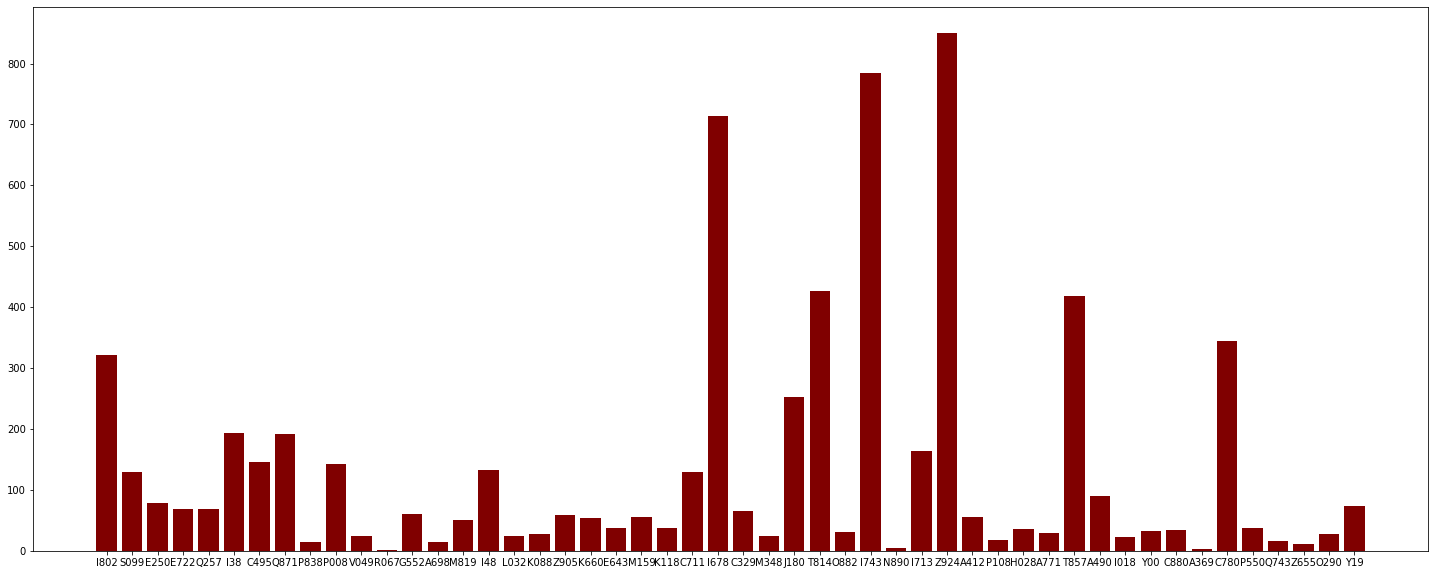

In [ ]:
dicClass=collections.Counter(df["ICD10"])

plt.figure(figsize=(25, 10))
plt.bar(list(dicClass.keys())[:50],list(dicClass.values())[:50], color="maroon")
plt.show()

Le jeu de données n'est pas équilibré, ainsi, la métrique à utiliser est la f1 score et non l'accuracy.

# **Exercice 2** : Classification du premier caractère du code CIM-10 à partir du langage naturel

In [ ]:
df_train['ICD10_1_Carac']=df_train['ICD10'].apply(lambda x: x[0])
df_test['ICD10_1_Carac']=df_test['ICD10'].apply(lambda x: x[0])
df_val['ICD10_1_Carac']=df_val['ICD10'].apply(lambda x: x[0])

df_train['ICD10_1_Carac']=preprocessing.LabelEncoder().fit_transform(df_train.ICD10_1_Carac.values)
df_test['ICD10_1_Carac']=preprocessing.LabelEncoder().fit_transform(df_test.ICD10_1_Carac.values)
df_val['ICD10_1_Carac']=preprocessing.LabelEncoder().fit_transform(df_val.ICD10_1_Carac.values)

In [ ]:
uniqueWords = list(set(" ".join(df_train['RawText']).lower().split(" ")))
max_features = len(uniqueWords)
print("Nombre de mots dans notre vocabulaire (après nettoyage: suppression de la ponctuation et mise en miniscule): ", max_features)

nbre_classes = len(set(df_train['ICD10_1_Carac']))
print("Nombre de classes : ", nbre_classes)

# La taille du vecteur document (première couche) doit être égale à la taille du document avec le plus grand nombre de mots
max_len = df_train.RawText.str.split(" ").str.len().max()
print("Taille des vecteurs qui contienderont les documents : ", max_len, "\n")

Nombre de mots dans notre vocabulaire (après nettoyage: suppression de la ponctuation et mise en miniscule):  28970
Nombre de classes :  26
Taille des vecteurs qui contienderont les documents :  32 



In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=28970, output_mode='int')

vectorize_layer.adapt(df_train["RawText"])

#Construction de notre réseau de neuronne 
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(28970, output_dim=32, mask_zero=True))
model.add(tf.keras.layers.LSTM(32, dropout=0.1))
model.add( tf.keras.layers.Dense(26,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("----- Entrainement du modèle -----")
model.fit(x=df_train["RawText"],y= df_train['ICD10_1_Carac'], epochs=5, validation_data=(df_val['RawText'], df_val['ICD10_1_Carac']))

print("\n----- Evaluation du modele  -----")
print("Accuracy:", model.evaluate(df_test['RawText'],df_test['ICD10_1_Carac'])[1])

yhat_probs = model.predict(df_test['RawText'], verbose=0)
y_pred = np.argmax(yhat_probs,axis=1)

print("\n----- Evaluation du modele : f1-Score  -----")
f1_score(df_test['ICD10_1_Carac'].to_numpy(), y_pred, average='weighted')

----- Entrainement du modèle -----
Epoch 1/5
5681/5681 [==============================] - 119s 20ms/step - loss: 1.2610 - accuracy: 0.6547 - val_loss: 0.7445 - val_accuracy: 0.7896
Epoch 2/5
5681/5681 [==============================] - 141s 25ms/step - loss: 0.5979 - accuracy: 0.8282 - val_loss: 0.6203 - val_accuracy: 0.8147
Epoch 3/5
5681/5681 [==============================] - 108s 19ms/step - loss: 0.4582 - accuracy: 0.8588 - val_loss: 0.5880 - val_accuracy: 0.8237
Epoch 4/5
5681/5681 [==============================] - 117s 21ms/step - loss: 0.3936 - accuracy: 0.8722 - val_loss: 0.5714 - val_accuracy: 0.8277
Epoch 5/5
5681/5681 [==============================] - 86s 15ms/step - loss: 0.3567 - accuracy: 0.8805 - val_loss: 0.5704 - val_accuracy: 0.8284

----- Evaluation du modele  -----
938/938 [==============================] - 6s 6ms/step - loss: 0.5661 - accuracy: 0.8333
Accuracy: 0.8332666754722595

----- Evaluation du modele : f1-Score  -----


0.8319900155222053

# **Exercice 3 :** Classification du code CIM-10 entier à partir du langage naturel

### Partie 1

In [ ]:
uniqueWords = list(set(" ".join(df_train['RawText']).lower().split(" ")))
max_features = len(uniqueWords)
print("Nombre de mots dans notre vocabulaire (après nettoyage) : ", max_features)

nbre_classes = len(set(df_train['ICD10']))
print("Nombre de classes: ", nbre_classes)

# La taille du vecteur document (première couche) doit être égale à la taille du document avec le plus grand nombre de mots
max_len = df_train.RawText.str.split(" ").str.len().max()
print("Taille des vecteurs qui contienderont les documents : ", max_len, "\n")

Nombre de mots dans notre vocabulaire (après nettoyage) :  28970
Nombre de classes dans le train :  9248
Taille des vecteurs qui contienderont les documents :  32 



In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=36326, output_mode='int')

vectorize_layer.adapt(df_train["RawText"])

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(input_dim=36326, output_dim = 32, mask_zero=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(9541, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("----- Entrainement du modèle -----")
model.fit(x=df_train["RawText"],y= y_train, epochs=8)

yhat_probs = model.predict(df_test['RawText'], verbose=0)
y_pred = np.argmax(yhat_probs,axis=1)

print("\n----- Evaluation du modele : f1-Score  -----")
f1_score(y_test, y_pred, average='weighted')

----- Entrainement du modèle -----
Epoch 1/8
5681/5681 [==============================] - 302s 52ms/step - loss: 6.8007 - accuracy: 0.0775
Epoch 2/8
5681/5681 [==============================] - 314s 55ms/step - loss: 4.1361 - accuracy: 0.2973
Epoch 3/8
5681/5681 [==============================] - 357s 63ms/step - loss: 2.7710 - accuracy: 0.4677
Epoch 4/8
5681/5681 [==============================] - 297s 52ms/step - loss: 2.0131 - accuracy: 0.5794
Epoch 5/8
5681/5681 [==============================] - 299s 53ms/step - loss: 1.5472 - accuracy: 0.6586
Epoch 6/8
5681/5681 [==============================] - 283s 50ms/step - loss: 1.2434 - accuracy: 0.7112
Epoch 7/8
5681/5681 [==============================] - 291s 51ms/step - loss: 1.0325 - accuracy: 0.7495
Epoch 8/8
5681/5681 [==============================] - 292s 51ms/step - loss: 0.8854 - accuracy: 0.7758

----- Evaluation du modele : f1-Score  -----


0.5848366311436312

Les résultats obtenus sont moins bons que ceux de l'exercice précédent. Ceci était prévisible pour plusieurs raisons:

*   Le très grand nombre de classe.
*   Pour certaines classes le modèle a appris que sur un exemple voir très très peu. (ce n'est pas suffisant pour qu'il puisse apprendre).
*   Le train set contient 9248 classes or que le jeu de données intégralement en contient 9541.



### Partie 2

In [ ]:
label_enc = preprocessing.LabelEncoder()
label_enc.fit(df_labels)
y_pred_decoded = label_enc.inverse_transform(y_pred)

In [ ]:
y_test_1_carac=df_test['ICD10'].apply(lambda x: x[0])
y_test_2_carac=df_test['ICD10'].apply(lambda x: x[0:2])
y_test_3_carac=df_test['ICD10'].apply(lambda x: x[0:3])

In [ ]:
y_pred_decoded_1_carac=[x[0] for x in y_pred_decoded]
y_pred_decoded_2_carac=[x[0:2] for x in y_pred_decoded]
y_pred_decoded_3_carac=[x[0:3] for x in y_pred_decoded]

In [ ]:
f1_score(y_test_1_carac, y_pred_decoded_1_carac, average='weighted')

0.7941435265952006

In [ ]:
f1_score(y_test_2_carac, y_pred_decoded_2_carac, average='weighted')

0.733186981647169

In [ ]:
f1_score(y_test_3_carac, y_pred_decoded_3_carac, average='weighted')

0.67241344755074

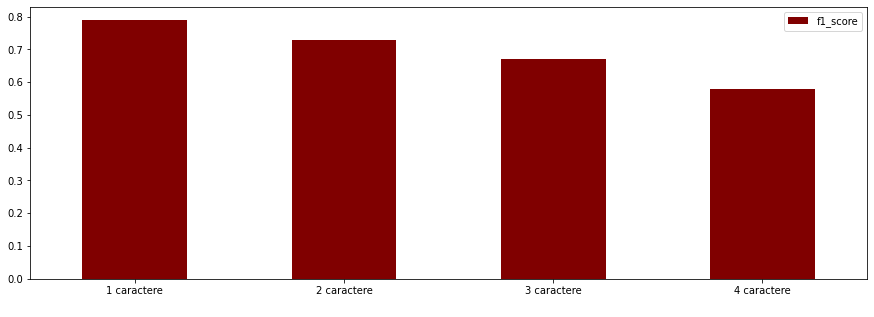

In [ ]:
df = pd.DataFrame({' ':['1 caractere', '2 caracteres','3 caracteres','4 caracteres'], 'f1_score':[0.79, 0.73, 0.67, 0.58]})
ax = df.plot.bar(x=' ', y='f1_score', rot=0, color='maroon', figsize=(15, 5))

Nous remarquons que plus le nombre de caractère augmente (augmentation du nombre de classes) plus notre f1_score diminue.  
Cela reste cohérent, il est plus évident de prédire 26 classes que des milliers de classes. Dans notre cas, il on arrive à bien prédire la pathologie en elle même, mais plus on essaie de prédire la variante, moins on a de bons résultats.

# **Exercice 4 :** Modèle seq2seq et prédiction gloutonne du code CIM-10 à partir du langage naturel

In [ ]:
train = df_train
test = df_test
val = df_val

## **Partie 1 : Ajustement du modèle par apprentissage forcé**

### **Convertision des labels en séquences de texte**

In [ ]:
train['ICD10'] = train['ICD10'].apply(lambda x : ' '.join(list(x)))
val['ICD10'] = val['ICD10'].apply(lambda x : ' '.join(list(x)))
test['ICD10'] = test['ICD10'].apply(lambda x : ' '.join(list(x)))
train.head()

,RawText,ICD10
0,Thrombose veineuse profonde cuisse gauche,I 8 0 2
1,Hémiplégie post-traumatique,S 0 9 9
2,Masculinisation avec hyperplasie surrénale,E 2 5 0
3,Hyperammoniémie cérébrale,E 7 2 2
4,Fistule artérioveineuse congénitale périphériq...,Q 2 5 7


In [ ]:
unique_words_input = list(set(" ".join(train['RawText']).lower().split(" ")))
num_words_input = len(unique_words_input)
print("Nombre de mots en entrée : ", num_words_input)

max_len_input = train.RawText.str.split(" ").str.len().max()
print("Taille des vecteurs en entrée : ", max_len_input, "\n")

unique_words_output = list(set(" ".join(train['ICD10']).lower().split(" ")))
num_words_output = len(unique_words_output)
print("Nombre de mots en sortie : ", num_words_output)

max_len_output = train.ICD10.str.split(" ").str.len().max() + 1
print("Taille des vecteurs en sortie : ", max_len_output, "\n")

Nombre de mots en entrée :  32062
Taille des vecteurs en entrée :  31 

Nombre de mots en sortie :  36
Taille des vecteurs en sortie :  5 



### **Création des séquences d'entrée de l'encodeur, des séquences d'entrée et de sortie du décodeur**

In [ ]:
input_sentences_train = train['RawText'].values.tolist()

list = train['ICD10'].values.tolist()
output_sentences_inputs_train = ['<start> ' + x for x in list]
output_sentences_train = [x + ' <end>' for x in list]


print(input_sentences_train[17])
print(output_sentences_train[17])
print(output_sentences_inputs_train[17])

Douleur dentaire, dents
K 0 8 8 <end>
<start> K 0 8 8


In [ ]:
# val data
input_sentences_val = val['RawText'].values.tolist()

list = val['ICD10'].values.tolist()
output_sentences_inputs_val = ['<start> ' + x for x in list]
output_sentences_val = [x + ' <end>' for x in list]

In [ ]:
# test data
input_sentences_test = test['RawText'].values.tolist()

list = test['ICD10'].values.tolist()
output_sentences_inputs_test = ['<start> ' + x for x in list]
output_sentences_test = [x + ' <end>' for x in list]

### **Text tokenization**

On transforme les mots de chaque phrase en un entier. Tous les mots du jeu de données sont stockés dans un dictionnaire. Les entiers sont les clés du dictionnaire. Pour accéder aux mots dans le dictionnaire, on aura besoin de ces entiers.


**Tokenize input sentences**

In [ ]:
input_tokenizer = Tokenizer(num_words=num_words_input)
input_tokenizer.fit_on_texts(input_sentences_train)

In [ ]:
# input sentences train
input_integer_seq_train = input_tokenizer.texts_to_sequences(input_sentences_train)

# input sentences validation
input_integer_seq_val = input_tokenizer.texts_to_sequences(input_sentences_val)

# input sentences test
input_integer_seq_test = input_tokenizer.texts_to_sequences(input_sentences_test)


word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

num_words_inputs = len(word2idx_inputs) + 1
max_input_len = max(len(sen) for sen in input_integer_seq_train)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 24660
Length of longest sentence in input: 31


**Tokenize output sentences**

In [ ]:
output_tokenizer = Tokenizer(num_words=num_words_output, filters='')
output_tokenizer.fit_on_texts(output_sentences_train + output_sentences_inputs_train)

In [ ]:
# output sentences train
output_input_integer_seq_train = output_tokenizer.texts_to_sequences(output_sentences_inputs_train)
output_integer_seq_train = output_tokenizer.texts_to_sequences(output_sentences_train)

# output sentences val
output_input_integer_seq_val = output_tokenizer.texts_to_sequences(output_sentences_inputs_val)
output_integer_seq_val = output_tokenizer.texts_to_sequences(output_sentences_val)

# output sentences test
output_input_integer_seq_test = output_tokenizer.texts_to_sequences(output_sentences_inputs_test)
output_integer_seq_test = output_tokenizer.texts_to_sequences(output_sentences_test)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq_train)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 38
Length of longest sentence in the output: 5


### **Padding aux séquences**

On ajoute du padding (valeur 0) à chaque phrase (liste d'entiers) afin qu'elles aient la même taille que la plus grande phrase du jeu de données.

**Encode input sentences**

In [ ]:
# train data
encoder_input_sequences_train = pad_sequences(input_integer_seq_train, maxlen=max_input_len)

# val data
encoder_input_sequences_val = pad_sequences(input_integer_seq_val, maxlen=max_input_len)

# test data
encoder_input_sequences_test = pad_sequences(input_integer_seq_test, maxlen=max_input_len)

print("encoder_input_sequences.shape:", encoder_input_sequences_train.shape)
print("encoder_input_sequences[17]:", encoder_input_sequences_train[17])
print(word2idx_inputs["douleur"], word2idx_inputs["dentaire"], word2idx_inputs["dents"])

encoder_input_sequences.shape: (181763, 31)
encoder_input_sequences[17]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  460  644 1555]
460 644 1555


**Decode input sentences**

In [ ]:
# train data
decoder_input_sequences_train = pad_sequences(output_input_integer_seq_train, maxlen=max_out_len, padding='post')

# val data
decoder_input_sequences_val = pad_sequences(output_input_integer_seq_val, maxlen=max_out_len, padding='post')

# test data
decoder_input_sequences_test = pad_sequences(output_input_integer_seq_test, maxlen=max_out_len, padding='post')


print("decoder_input_sequences.shape:", decoder_input_sequences_train.shape)
print("decoder_input_sequences[17]:", decoder_input_sequences_train[17])
print(word2idx_outputs["<start>"], word2idx_outputs["k"], word2idx_outputs["0"], word2idx_outputs["8"], word2idx_outputs["8"])

decoder_input_sequences.shape: (181763, 5)
decoder_input_sequences[17]: [ 2 19  4  3  3]
2 19 4 3 3


**Decode output sequences**

In [ ]:
# train data
decoder_output_sequences_train = pad_sequences(output_integer_seq_train, maxlen=max_out_len, padding='post')

# val data
decoder_output_sequences_val = pad_sequences(output_integer_seq_val, maxlen=max_out_len, padding='post')

# test data
decoder_output_sequences_test = pad_sequences(output_integer_seq_test, maxlen=max_out_len, padding='post')


print("decoder_output_sequences.shape:", decoder_output_sequences_train.shape)
print("decoder_output_sequences[171]:", decoder_output_sequences_train[17])
print(word2idx_outputs["k"], word2idx_outputs["0"], word2idx_outputs["8"], word2idx_outputs["8"], word2idx_outputs["<end>"])

decoder_output_sequences.shape: (181763, 5)
decoder_output_sequences[171]: [19  4  3  3  1]
19 4 3 3 1


**Valeur à prédire**

In [ ]:
# train data
decoder_targets_one_hot_train = np.zeros((
        len(input_sentences_train),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

decoder_targets_one_hot_train.shape

for i, d in enumerate(decoder_output_sequences_train):
    for t, word in enumerate(d):
        decoder_targets_one_hot_train[i, t, word] = 1

In [ ]:
# val data
decoder_targets_one_hot_val = np.zeros((
        len(input_sentences_val),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
for i, d in enumerate(decoder_output_sequences_val):
    for t, word in enumerate(d):
        decoder_targets_one_hot_val[i, t, word] = 1

In [ ]:
# test data
decoder_targets_one_hot_test = np.zeros((
        len(input_sentences_test),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
for i, d in enumerate(decoder_output_sequences_test):
    for t, word in enumerate(d):
        decoder_targets_one_hot_test[i, t, word] = 1

### **Implémentation du modèle**

**Encodeur**

In [ ]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))

encoder_embedding = Embedding(num_words_inputs, 256)
x = encoder_embedding(encoder_inputs_placeholder)
encoder = LSTM(256, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

**Décodeur**

In [ ]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, 256)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

**Décodeur prédiction**

In [ ]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

### **Compilation du modèle**

In [ ]:
model = Model(inputs = [encoder_inputs_placeholder, decoder_inputs_placeholder], 
              outputs = decoder_outputs
              )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Dans ce modèle, on ne considère pas les prédictions relatives au padding dans la fonction objectif.
De même, les métriques ne considèrent pas le padding dans leur estimation. Mais il aurait put être intéressant d'inclure le padding lors de l'évaluation.

In [ ]:
model.fit(
    [encoder_input_sequences_train, decoder_input_sequences_train], decoder_targets_one_hot_train,
    batch_size=64,
    epochs=5,
    validation_data=([encoder_input_sequences_val, decoder_input_sequences_val], decoder_targets_one_hot_val),
)

Epoch 1/5
2841/2841 [==============================] - 104s 34ms/step - loss: 1.1287 - accuracy: 0.6326 - val_loss: 0.7503 - val_accuracy: 0.7623
Epoch 2/5
2841/2841 [==============================] - 96s 34ms/step - loss: 0.5624 - accuracy: 0.8227 - val_loss: 0.5620 - val_accuracy: 0.8254
Epoch 3/5
2841/2841 [==============================] - 96s 34ms/step - loss: 0.3813 - accuracy: 0.8789 - val_loss: 0.5010 - val_accuracy: 0.8487
Epoch 4/5
2841/2841 [==============================] - 96s 34ms/step - loss: 0.2911 - accuracy: 0.9067 - val_loss: 0.4820 - val_accuracy: 0.8582
Epoch 5/5
2841/2841 [==============================] - 96s 34ms/step - loss: 0.2351 - accuracy: 0.9232 - val_loss: 0.4786 - val_accuracy: 0.8635


L'entrainement du modèle sur le jeu de données de validation montre une accuracy de 86%, ce qui est très bon.

In [ ]:
results = model.evaluate([encoder_input_sequences_test, decoder_input_sequences_test], decoder_targets_one_hot_test, batch_size=64)
print("test loss, test acc:", results)

469/469 [==============================] - 5s 11ms/step - loss: 0.4754 - accuracy: 0.8644
test loss, test acc: [0.47539907693862915, 0.864359974861145]


  L'évaluation du modèle sur le jeu de données de test montre une accuracy de 86%. Le modèle a de bonnes performances

### **Enregistrement des poids du modèle**

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

## **Partie : 2 Prédictions gloutonnes à partir d’un modèle ajusté**

In [ ]:
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
# function to predict code ICD10
# input_seq : input sequence in the encoder, patient symptoms
# return code ICD10
def predict_sequence(input_seq):

    # first word of the output sentence
    output_sentence = ['<start>']

    # transform each text in texts to a sequence of integers
    # padding 0 in the sequence until it has the same length as the longest input sequence in the model
    input_in = input_tokenizer.texts_to_sequences([input_seq])
    encoder_input_sequence = pad_sequences(input_in, maxlen=max_input_len)

    for i in range(max_out_len -1):
      # transform each text in texts to a sequence of integers
      # padding 0 in the sequence until it has the same length as the longest output sequence in the model
      output_in = output_tokenizer.texts_to_sequences(output_sentence)
      decoder_input_sequences = pad_sequences(output_in, maxlen=max_out_len, padding='post')

      # predict code IDC10 based on the input sentence and the previous output from the decoder
      output_tokens = model.predict([encoder_input_sequence, decoder_input_sequences])

      # get the word with the highest probability
      idx = np.argmax(output_tokens[0, i, :])
      word = idx2word_target[idx]

      # concanate the predicted word with the previous sentence predicted
      output_sentence.append(word) 
      output_sentence = [' '.join(output_sentence)]

    # remove fist element <start>
    final_output = ''.join(output_sentence)
    final_output = final_output.split()
    final_output.pop(0)

    return ''.join(final_output).upper()

In [ ]:
# Exemple de la prédiction d'un code ICD10 à partir d'une phrase

input_seq = 'Thrombose veineuse profonde cuisse gauche'

output_seq = predict_sequence(input_seq)

print('Input:', input_seq)
print('Output:', output_seq)

Input: Thrombose veineuse profonde cuisse gauche
Output: I802


### **Prédiction gloutonne sur le jeu de données de validation**

In [ ]:
y_true = []
y_pred = []

for i in range(len(val['RawText'])):
  input_seq = val['RawText'][i]

  expected_seq = val['ICD10'][i].replace(" ", "")
  y_true.append(expected_seq)

  output_seq = predict_sequence(input_seq)
  y_pred.append(output_seq)

f1_score(y_true,y_pred, average='weighted')

0.5130666666666667

Avec la prédiction gloutonne, on a un f1-score de 51%, ce qui est plus faible que le modèle de classification classique ajusté précédemment. 

# **Exercice 5 :** Pour aller plus loin

## Point 1

Dans le but d'améliorer notre modèle, nous allons effectuer un nettoyage de texte, puis réexécuter nos algorithmes et comparer les résultats.

### Install

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 14.7 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
!spacy download fr_core_news_sm

     |████████████████████████████████| 14.7 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


### Nettoyage du texte

In [ ]:
import re
from nltk.corpus import stopwords

import spacy
import fr_core_news_sm

from nltk.stem.snowball import SnowballStemmer

In [ ]:
nlp = spacy.load("fr_core_news_sm")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = stopwords.words('french')

def clean_text(
    string: str,
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=stop_words) -> str:
    """
    A method to clean text - preprocessing
    """
    #Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+','',string)

    #Cleaning the html elements
    string = re.sub(r'<.*?>','',string)

    #Cleaning numbers
    #string = re.sub(r'[0-9]+','',string)

    #Removing the punctuations
    for x in string.lower():
      if x in punctuations:
        string = string.replace(x,"")
    
    #Converting to the text to lower
    string = string.lower()

    #Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])
    
    #Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    #Lemmatization
    stemmer = SnowballStemmer(language='french')
    doc = nlp(string)
    string_final = ' '.join([stemmer.stem(token.text) for token in doc])
  
    return string_final

In [ ]:
df_list=[clean_text(x) for x in df_train['RawText'].astype(str)]
df_train = pd.DataFrame(list(zip(df_list, list(df_train['ICD10']))), columns =['RawText', 'ICD10'])

In [ ]:
df_list=[clean_text(x) for x in df_test['RawText'].astype(str)]
df_test = pd.DataFrame(list(zip(df_list, list(df_test['ICD10']))), columns =['RawText', 'ICD10'])


In [ ]:
df_list=[clean_text(x) for x in df_val['RawText'].astype(str)]
df_val = pd.DataFrame(list(zip(df_list, list(df_val['ICD10']))), columns =['RawText', 'ICD10'])

### Classification du premier caractère du code CIM-10 à partir du langage naturel

In [ ]:
df_train['ICD10_1_Carac']=df_train['ICD10'].apply(lambda x: x[0])
df_test['ICD10_1_Carac']=df_test['ICD10'].apply(lambda x: x[0])
df_val['ICD10_1_Carac']=df_val['ICD10'].apply(lambda x: x[0])

df_train['ICD10_1_Carac']=preprocessing.LabelEncoder().fit_transform(df_train.ICD10_1_Carac.values)
df_test['ICD10_1_Carac']=preprocessing.LabelEncoder().fit_transform(df_test.ICD10_1_Carac.values)
df_val['ICD10_1_Carac']=preprocessing.LabelEncoder().fit_transform(df_val.ICD10_1_Carac.values)

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=28970, output_mode='int')

vectorize_layer.adapt(df_train["RawText"])

#Construction de notre réseau de neuronne 
model = tf.keras.models.Sequential()

model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(28970, output_dim=32, mask_zero=True))
model.add(tf.keras.layers.LSTM(32, dropout=0.1))
model.add( tf.keras.layers.Dense(26,activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("----- Entrainement du modèle -----")
model.fit(x=df_train["RawText"],y= df_train['ICD10_1_Carac'], epochs=5, validation_data=(df_val['RawText'], df_val['ICD10_1_Carac']))

print("----- Evaluation du modele : accuracy -----")
model.evaluate(df_test['RawText'],df_test['ICD10_1_Carac'])

print("----- Evaluation du modele : recall -----")
model.evaluate(df_test['RawText'],df_test['ICD10_1_Carac'])

----- Entrainement du modèle -----
Epoch 1/5
5681/5681 [==============================] - 97s 16ms/step - loss: 1.2264 - accuracy: 0.6675 - val_loss: 0.7446 - val_accuracy: 0.7912
Epoch 2/5
5681/5681 [==============================] - 93s 16ms/step - loss: 0.6048 - accuracy: 0.8260 - val_loss: 0.6154 - val_accuracy: 0.8204
Epoch 3/5
5681/5681 [==============================] - 90s 16ms/step - loss: 0.4728 - accuracy: 0.8555 - val_loss: 0.5845 - val_accuracy: 0.8229
Epoch 4/5
5681/5681 [==============================] - 86s 15ms/step - loss: 0.4132 - accuracy: 0.8668 - val_loss: 0.5640 - val_accuracy: 0.8284
Epoch 5/5
5681/5681 [==============================] - 91s 16ms/step - loss: 0.3781 - accuracy: 0.8749 - val_loss: 0.5588 - val_accuracy: 0.8293
----- Evaluation du modele : accuracy -----
938/938 [==============================] - 6s 7ms/step - loss: 0.5544 - accuracy: 0.8304
----- Evaluation du modele : recall -----
938/938 [==============================] - 6s 7ms/step - loss: 0.

[0.5544145703315735, 0.8304333090782166]

In [ ]:
yhat_probs = model.predict(df_test['RawText'], verbose=0)
y_pred = np.argmax(yhat_probs,axis=1)

print("\n----- Evaluation du modele : f1-Score  -----")
f1_score(df_test['ICD10_1_Carac'].to_numpy(), y_pred, average='weighted')


----- Evaluation du modele : f1-Score  -----


0.8309936201163005

Nous constatons, que malgré notre amélioration de la méthode de nettoyage du texte, nous n'avons pas forcément obtenu de meilleurs résultats.

### Classification du code CIM-10 entier à partir du langage naturel

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_val = pd.read_csv("val.csv")

df_labels=pd.concat([df_train['ICD10'], df_test['ICD10'],df_val['ICD10']])
labels=preprocessing.LabelEncoder().fit_transform(df_labels)

y_train = labels[:181763]
y_test = labels[181763:211763]
y_val = labels[211763:241763]

In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=36326, output_mode='int')

vectorize_layer.adapt(df_train["RawText"])

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(input_dim=36326, output_dim = 32, mask_zero=True))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(9541, activation="softmax"))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("----- Entrainement du modèle -----")
model.fit(x=df_train["RawText"],y= y_train, epochs=8)

yhat_probs = model.predict(df_test['RawText'], verbose=0)
y_pred = np.argmax(yhat_probs,axis=1)

print("\n----- Evaluation du modele : f1-Score  -----")
f1_score(y_test, y_pred, average='weighted')

----- Entrainement du modèle -----
Epoch 1/8
5681/5681 [==============================] - 173s 29ms/step - loss: 6.8534 - accuracy: 0.0722
Epoch 2/8
5681/5681 [==============================] - 154s 27ms/step - loss: 4.1446 - accuracy: 0.2951
Epoch 3/8
5681/5681 [==============================] - 148s 26ms/step - loss: 2.7732 - accuracy: 0.4652
Epoch 4/8
5681/5681 [==============================] - 164s 29ms/step - loss: 2.0255 - accuracy: 0.5791
Epoch 5/8
5681/5681 [==============================] - 147s 26ms/step - loss: 1.5645 - accuracy: 0.6559
Epoch 6/8
5681/5681 [==============================] - 153s 27ms/step - loss: 1.2563 - accuracy: 0.7093
Epoch 7/8
5681/5681 [==============================] - 146s 26ms/step - loss: 1.0460 - accuracy: 0.7469
Epoch 8/8
5681/5681 [==============================] - 143s 25ms/step - loss: 0.8948 - accuracy: 0.7744

----- Evaluation du modele : f1-Score  -----


0.5845924508323891

Pareil ici, nous constatons que malgré notre amélioration de la méthode de nettoyage du texte, nous n'avons pas forcément obtenu de meilleurs résultats.

## Point 2

### Initialisation du tokenizer. Création du vocabulaire à partir des données d'entrainement

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(df_train.RawText, target_vocab_size=2**13)

In [ ]:
print("bronchopneumo fulminante enterobacter")
test_tokens = tokenizer.encode("pneumocardio fulminante enterobacter")
print(test_tokens)

bronchopneumo fulminante enterobacter
[1911, 100, 7933, 4860, 3667]


In [ ]:
for token in test_tokens:
  print(tokenizer.decode([token]))

pneumo
cardio
 
fulminante 
enterobacter


On voit que le tokenizer arrive à decomposer "pneumocardio" en deux sous-mots "pneumo" et "cardio"

In [ ]:
# Transforme une liste de strings en liste de vecteurs
def tokenize(tokenizer, data):
  tokenized_data = []
  for row in data:
    tokenized_data.append(tokenizer.encode(row))
  return tokenized_data

# Transforme une liste de vecteurs en liste de strings 
def detokenize(tokenizer, tokenized_data):
  data = []
  for row in tokenized_data:
    data.append(tokenizer.decode(row))
  return data

In [ ]:
# Test des methodes avec les 3 premières lignes des données d'entrainement

tokenized_data = tokenize(tokenizer, df_train['RawText'][:3].values.tolist())
print(tokenized_data)
detokenized_data = detokenize(tokenizer, tokenized_data)
print(detokenized_data)

[[40, 203, 674, 354, 5], [741, 16, 7946, 136], [1955, 1958, 7, 3850, 2446]]
['thrombose veineuse profonde cuisse gauche', 'hémiplégie post-traumatique', 'masculinisation avec hyperplasie surrénale']


### Tokenisation des différents jeux de données

In [ ]:
train_data = tokenize(tokenizer, df_train['RawText'].values.tolist())
test_data = tokenize(tokenizer, df_test['RawText'].values.tolist())
vzl_data = tokenize(tokenizer, df_val['RawText'].values.tolist())

On ajoute un padding pour que tous les datasets aient les mêmes dimensions afin de pouvoir utiliser les modèles de keras

In [ ]:
max_len = np.max([pd.Series(train_data).str.len().max(),
                  pd.Series(test_data).str.len().max(),
                  pd.Series(vzl_data).str.len().max()])

In [ ]:
train_data = pad_sequences(train_data, maxlen=max_len, padding='post')
test_data = pad_sequences(test_data, maxlen=max_len, padding='post')
val_data = pad_sequences(vzl_data, maxlen=max_len, padding='post')

In [ ]:
x_train = tf.expand_dims(train_data, axis=1)
x_test = tf.expand_dims(test_data, axis=1)
x_val = tf.expand_dims(val_data, axis=1)


y_train = tf.expand_dims(df_train['ICD10_1_Carac'], axis=1)
y_test = tf.expand_dims(df_test['ICD10_1_Carac'], axis=1)
y_val = tf.expand_dims(df_val['ICD10_1_Carac'], axis=1)

### Entrainement du modèle avec le nouveau jeu de données

In [ ]:
from tensorflow import keras
from keras.layers import Dense, LayerNormalization, LSTM, Embedding, GlobalAveragePooling1D, TextVectorization, Conv1D, Flatten


model = tf.keras.Sequential([
                             Embedding(input_dim=8096, output_dim=30, mask_zero=True, input_length=max_len),
                             LSTM(30, dropout=0.2, recurrent_dropout=0., return_sequences=True),
                             LSTM(30, dropout=0.2, recurrent_dropout=0., return_sequences=True),
                             GlobalAveragePooling1D(),
                             Dense(nbre_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("----- Entrainement du modèle -----")
model.fit(train_data, y_train, epochs=15, batch_size=32, validation_data=(val_data, y_val))

----- Entrainement du modèle -----
Epoch 1/15
5681/5681 [==============================] - 75s 11ms/step - loss: 1.6604 - accuracy: 0.5333 - val_loss: 1.0522 - val_accuracy: 0.7105
Epoch 2/15
5681/5681 [==============================] - 62s 11ms/step - loss: 0.9607 - accuracy: 0.7309 - val_loss: 0.8378 - val_accuracy: 0.7657
Epoch 3/15
5681/5681 [==============================] - 62s 11ms/step - loss: 0.8051 - accuracy: 0.7680 - val_loss: 0.7507 - val_accuracy: 0.7855
Epoch 4/15
5681/5681 [==============================] - 62s 11ms/step - loss: 0.7266 - accuracy: 0.7858 - val_loss: 0.6954 - val_accuracy: 0.7963
Epoch 5/15
5681/5681 [==============================] - 68s 12ms/step - loss: 0.6721 - accuracy: 0.7987 - val_loss: 0.6667 - val_accuracy: 0.8042
Epoch 6/15
5681/5681 [==============================] - 62s 11ms/step - loss: 0.6339 - accuracy: 0.8071 - val_loss: 0.6425 - val_accuracy: 0.8089
Epoch 7/15
5681/5681 [==============================] - 62s 11ms/step - loss: 0.6048 - ac

In [ ]:
print("\n----- Evaluation du modele  -----")
print("Accuracy:", model.evaluate(test_data, y_test)[1])

yhat_probs = model.predict(test_data, verbose=0)
y_pred = np.argmax(yhat_probs,axis=1)

print("\n----- Evaluation du modele : f1-Score  -----")
f1_score(y_test, y_pred, average='weighted')


----- Evaluation du modele  -----
938/938 [==============================] - 4s 4ms/step - loss: 0.5570 - accuracy: 0.8320
Accuracy: 0.8320333361625671

----- Evaluation du modele : f1-Score  -----


0.8290298193182769

On remarque que pour notre problème, decomposer le texte en sous mots améliore légèrement le résultat obtenu. En effet on obtient des métriques similaires à celles que l'on avait quand on tokenisait les documents seul, mais on peut aussi constater que le modèle n'a pas tendance à sur-apprendre malgré le nombre d'epochs élevé, ce qui n'était pas le cas avec le modèle vu plus haut. Toutefois, les points gagnés en terme de performance de modèle se compensent avec le temps d'entrainement qu'on pourrait juger un peu long.

## Point 4

Une convolution standard ne prenant pas en compte la direction de

In [ ]:
from tensorflow import keras
import tensorflow as tf

model = tf.keras.Sequential([
                             keras.layers.Conv1D(32, 5, padding='causal', strides=2, input_shape=x.shape[1:]),
                             keras.layers.Conv1D(32, 5, padding='causal', strides=2),
                             LSTM(30, dropout=0.2, recurrent_dropout=0., return_sequences=True),
                             #keras.layers.GlobalAveragePooling1D(),
                             keras.layers.Dense(nbre_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x, y_train, epochs=5) #,batch_size=32, validation_data=(x_val, y_val))

Epoch 1/5
5681/5681 [==============================] - 31s 5ms/step - loss: 3.0295 - accuracy: 0.1217
Epoch 2/5
5681/5681 [==============================] - 25s 4ms/step - loss: 2.9965 - accuracy: 0.1301
Epoch 3/5
5681/5681 [==============================] - 26s 5ms/step - loss: 2.9926 - accuracy: 0.1304
Epoch 4/5
5681/5681 [==============================] - 26s 5ms/step - loss: 2.9858 - accuracy: 0.1319
Epoch 5/5
5681/5681 [==============================] - 27s 5ms/step - loss: 2.9869 - accuracy: 0.1314


In [ ]:
print("\n----- Evaluation du modele  -----")
x_test = tf.expand_dims(test_data, axis=1)
print("Accuracy:", model.evaluate(x_test, y_test)[1])


----- Evaluation du modele  -----
938/938 [==============================] - 3s 3ms/step - loss: 2.9992 - accuracy: 0.1265
Accuracy: 0.1264999955892563


## Point 5

In [ ]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
inp = train['RawText'].values.tolist()
targ = train['ICD10'].values.tolist()

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
#Pré-traitement du texte
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
#Vectorisation du texte
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
#La méthode adapt initialise la couche sur la base des données. Ici, il détermine le vocabulaire
input_text_processor.adapt(inp)

#Voici les 10 premiers mots du vocabulaire :
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'de', 'aussi', 'voir', 'gauche', 'nca', 'à']

In [ ]:
#C'est le text 'TextVectorization' couche, construire maintenant avec .adapt() les classes 
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 's062',
 'c798',
 'c859',
 'c349',
 'z924',
 'i251']

In [ ]:
embedding_dim = 256
units = 1024

In [ ]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
class Encoder(tf.keras.layers.Layer):
  '''
  return : 
      output : la séquence traitée.
      stat : l'état interne qui sera utilisé pour initialiser le décodeur.
  '''
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(units)

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
'''le décodeur prend 4 paramètres :
  new_tokens : le dernier jeton généré. Initialiser le décodeur avec le "[START]" jeton.
  enc_output : il est généré par l'Encoder.
  mask : tenseur booléen.
  state : le précédent state de sortie du décodeur.
'''
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
#Fonction de perte
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [ ]:
#Mettre en oeuvre l'étape de formation
class TrainModel(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
'''
Cette fonction reçoit un lot de 'input_text', 'target_text' du tf.data.Dataset,
puis convertit ces entrées de texte brut en incorporations de jetons et masques.
'''
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainModel._preprocess = _preprocess

In [ ]:
'''
Cette fonction exécute l'encodeur sur les 'input_tokens' pour obtenir le 'encoder_output' 
et 'encoder_state', initialise l'état et la perte du décodeur, boucle sur les 'target_tokens' 
pour donner la perte moyenne, puis calcule le gradient de la perte et utilise l'optimiseur 
pour appliquer les mises à jour à du modèle 'trainable_variables' .
'''
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainModel._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainModel._loop_step = _loop_step

In [ ]:
model = TrainModel(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
#Tester l'étape de formation
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainModel._tf_train_step = _tf_train_step

In [ ]:
model.use_tf_function = True

In [ ]:
#Entrainer le modèle
train_model = TrainModel(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_model.fit(dataset, epochs=3,
                     callbacks=[batch_loss])

Epoch 1/3
2841/2841 [==============================] - 3684s 1s/step - batch_loss: 1.6416
Epoch 2/3
2841/2841 [==============================] - 3666s 1s/step - batch_loss: 0.8475
Epoch 3/3
2841/2841 [==============================] - 3674s 1s/step - batch_loss: 0.6855


Text(0, 0.5, 'CE/token')

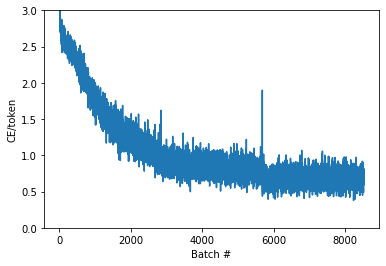

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

Remarque : les sauts visibles dans l'intrigue sont aux limites de l'époque.

In [ ]:
class Model(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
model = Model(
    encoder=train_model.encoder,
    decoder=train_model.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
#Convertir les identifiants de jeton en texte.
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Model.tokens_to_text = tokens_to_text

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Model.sample = sample

In [ ]:
def model_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Model.translate = model_unrolled

In [ ]:
#Exécution sur une simple entrée 
%%time
input_text = tf.constant([
    'Gangrène due à spirochètes NCA.', # "A698"
    'Thrombose veineuse profonde cuisse gauche', # "I802""
])

result = model.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

a698
i802

CPU times: user 197 ms, sys: 3.05 ms, total: 200 ms
Wall time: 187 ms


In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_model(self, input_text):
  return self.model(input_text)

Model.tf_model = tf_model

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_model(self, input_text):
  return self.translate(input_text)

Model.tf_model = tf_model

In [ ]:
%%time
result = model.tf_model(
    input_text = input_text)

CPU times: user 27.2 s, sys: 703 ms, total: 27.9 s
Wall time: 27.4 s


In [ ]:
#Un autr test
%%time
three_input_text = tf.constant([
    # I38.
    'Prothèse valvulaire mécanique.',
    # 489F
    'Névropathie',
    # C07'
    'Tumeur mixte parotide dégénérée',
])

result = model.tf_model(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

z952
g819
c07

CPU times: user 917 ms, sys: 28.2 ms, total: 945 ms
Wall time: 583 ms


In [ ]:
result['text']

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'z952', b'g819', b'c07'], dtype=object)>

In [ ]:
tf.saved_model.save(model, 'model',
                    signatures={'serving_default': model.tf_model})

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [ ]:
reloaded = tf.saved_model.load('model')
#result = reloaded.tf_model(three_input_text)

In [ ]:
%%time
result = reloaded.tf_model(three_input_text)
for tr in result['text']:
  print(tr.numpy().decode())

print()

z952
x44
c07

CPU times: user 929 ms, sys: 30.2 ms, total: 959 ms
Wall time: 590 ms


In [ ]:
# Un autre test

three_input_text = tf.constant([
    # Y19.
    'Toxique',
    # A183
    'Péritonite tuberculeuse',
    # 489F'
    'Névropathie',
])

result = reloaded.tf_model(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

y19
a183
z904

